In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.basemap import Basemap, cm
import pyowm
import time
from geopy.distance import geodesic
from math import sqrt

#Define a distance
def sq_distance(lon1, lat1, lon2, lat2):
    d = (lon2-lon1)**2 + (lat2-lat1)**2
    #d = geodesic((lat1, lon1), (lat2, lon2)).km
    return d
    
#Nearest neighbor with plane euclidian distance
def NNI_temp(xlon, xlat, ylon, ylat, temp, prediction):
    nx = prediction.shape[0]
    ny = prediction.shape[1]
    for i_x in range(0, nx):
        if i_x % 50 == 0:
            print('i_x = %d' % i_x)
        for i_y in range(0, ny):
            distance_to_closest = 0
            idx_closest = -1
            distance = 0
            for it in range(0, len(xlon)):
                distance = sq_distance(glons[i_x][i_y], glats[i_x][i_y], lon[it], lat[it])
                if (idx_closest < 0):
                    distance_to_closest = distance
                    idx_closest = it
                elif (distance_to_closest > distance):
                    distance_to_closest = distance
                    idx_closest = it
            prediction[i_x][i_y] = temp[idx_closest]['temp']
            

            
#Inverse distance weighting
#Param: radius of the IDW, if no points in the radius -> NNI 
def IDW_temp(xlon, xlat, ylon, ylat, temp, prediction, radius):
    nx = prediction.shape[0]
    ny = prediction.shape[1]
    for i_x in range(0, nx):
        if i_x % 50 == 0:
            print('i_x = %d' % i_x)
        for i_y in range(0, ny):
            numerator = 0
            denominator = 0
            idx_closest = -1
            distance = 0
            distance_to_closest = 0
            for it in range(0, len(xlon)):
                distance = sqrt(sq_distance(glons[i_x][i_y], glats[i_x][i_y], lon[it], lat[it]))
                if (idx_closest < 0):
                    distance_to_closest = distance
                    idx_closest = it
                elif (distance_to_closest > distance):
                    distance_to_closest = distance
                    idx_closest = it
                if (distance < radius):
                    numerator += temp[it]['temp']/distance
                    denominator += 1/distance
            if (denominator == 0):
                prediction[i_x][i_y] = temp[idx_closest]['temp']
            else:
                prediction[i_x][i_y] = numerator/denominator
        

In [2]:
#Retrieve api-key
with open('api-key/owm-api-key.txt', 'r') as key_file:
    key = key_file.read()

owm = pyowm.OWM(key)

In [3]:
#Read cities list
cities = pd.read_csv("data/cities.csv", ';')
valid_cities = []

dic = owm.city_id_registry()

for index, row in cities.iterrows():
    lookup = dic.locations_for(row['City'])
    if lookup==[]:
        print(row['City'])
    else:
        valid_cities.append(lookup[0])

Enfidha


D:\Apps\Programs\Anaconda2\lib\site-packages\pyowm\webapi25\cityidregistry.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  'nocase': lambda city_name, toponym: city_name.lower() == toponym.lower(),


Ghardaïa
Bou Saâda
Ténès
Gümü?hane
Karabük
Cádiz
Bruxelles
Vopnafjörður
Kökar
Jämsä
Båtsfjord


In [4]:
#Get cities coordinates and ID
lon = []
lat = []
ids = []
for city in valid_cities:
    lon.append(city.get_lon())
    lat.append(city.get_lat())
    ids.append(city.get_ID())

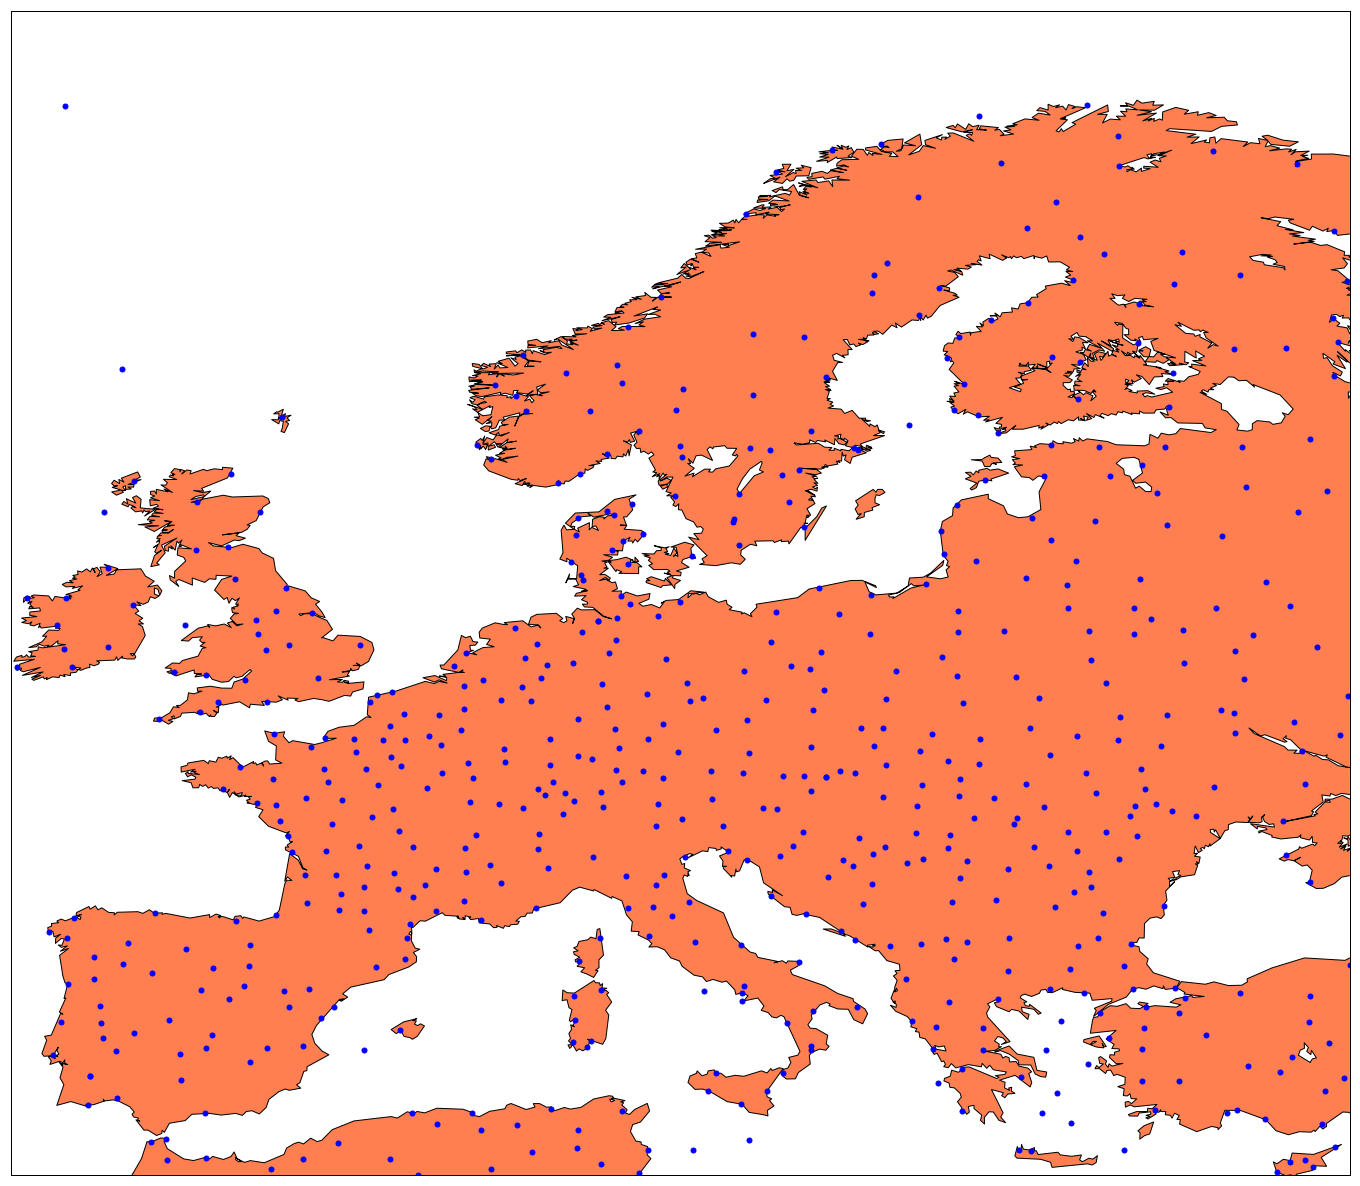

In [5]:
#Plot the cities on a map
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=-10.56,llcrnrlat=34.65,urcrnrlon=34.88,urcrnrlat=74.17, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()
x, y = map(lon, lat)
map.plot(x, y, 'bo', markersize=5)

In [12]:
#Get the observations for each city via the OWM API
observation_list = []
id20s = []
elt_id20 = []
c = 0

#Regroup IDs in lists of 20, maximum observation number per query
for c in range(0, len(ids)):
    elt_id20.append(ids[c])
    if len(elt_id20) == 20 or c == len(ids)-1:
        id20s.append(elt_id20)
        elt_id20 = []
    c = c + 1

for id20 in id20s:
    temp = owm.weather_at_ids(id20)
    time.sleep(1)
    observation_list.append(temp)

In [13]:
#Get weather and temperature for each city
weathers = []
temps = []

for obss in observation_list:
    for obs in obss:
        weathers.append(obs.get_weather())
        
for weather in weathers:
    temps.append(weather.get_temperature(unit='celsius'))

i_x = 0
i_x = 50


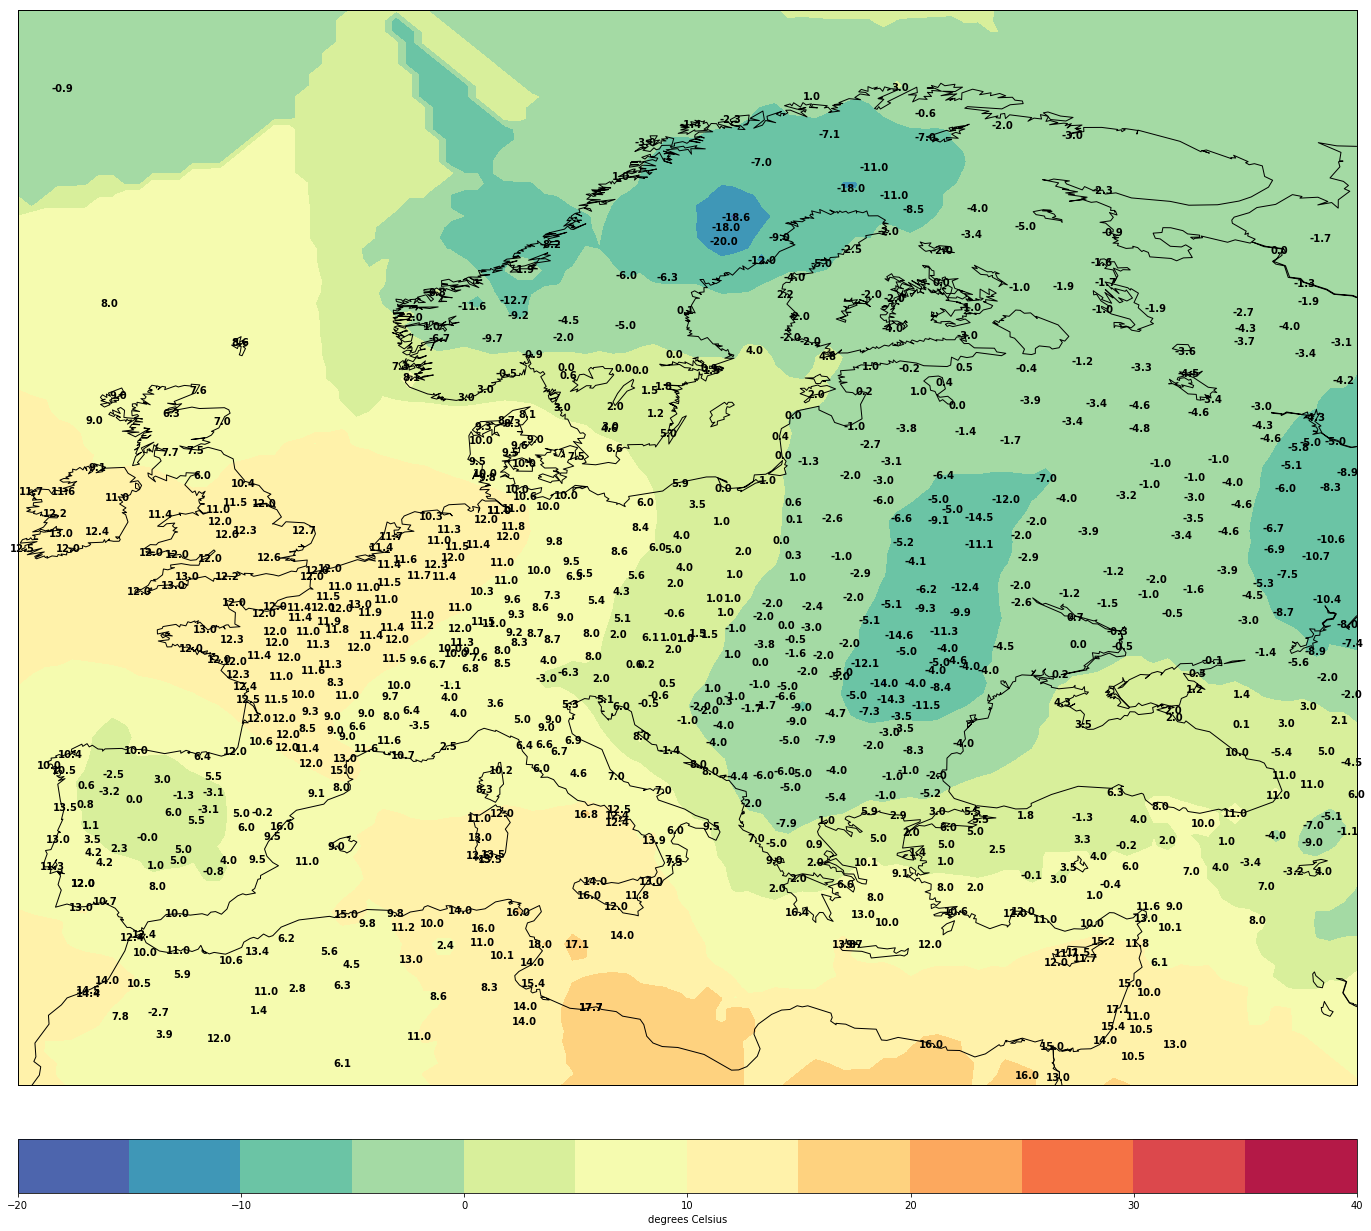

In [18]:
#Map boundaries
lon_min = -10.56
lat_min = 29.65
lon_max = 44.88
lat_max = 74.17

#Interpolation resolution
nx = 100
ny = 100

x_in_bounds = []
y_in_bounds = []
temps_in_bounds = []

#Create map
plt.figure(figsize=(24,24))
map = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max, resolution = 'l', epsg=4668)
map.drawmapboundary(fill_color='white')
#map.fillcontinents(color='coral',lake_color='white')
map.drawcoastlines()

x, y = map(lon, lat)

#Create annotations for temperature and only keep cities in bound
for i in range(0,len(x)-1):
    if lon[i] > lon_min and lon[i] < lon_max and lat[i] > lat_min and lat[i] < lat_max:
        plt.text(x[i], y[i], "{0:.1f}".format(temps[i]['temp']),fontsize=10,fontweight='bold', ha='center',va='center',color='k')
        x_in_bounds.append(x[i])
        y_in_bounds.append(y[i])
        temps_in_bounds.append(temps[i]['temp'])

glons, glats = map.makegrid(nx, ny)
gx, gy = map(glons, glats)
predict = np.zeros((nx, ny))

#Interpolation
#NNI_temp(lon, lat, glons, glats, temps, predict)
IDW_temp(lon, lat, glons, glats, temps, predict, 5)

#Plot contours
clevs = [-20,-15,-10,-5,0,5,10,15,20,25,30,35,40]
cs = map.contourf(gx,gy,predict,clevs,cmap='Spectral_r')

#Display colorbar
cbar = map.colorbar(cs,location='bottom',pad="5%")
cbar.set_label('degrees Celsius')